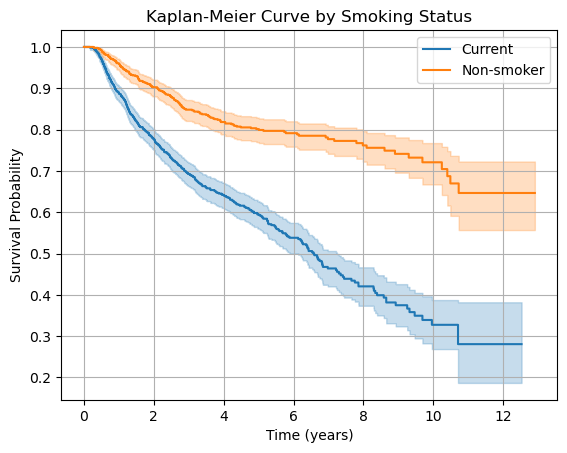

Log-rank test between Current and Non-smoker: p-value = 3.8797010741215883e-29


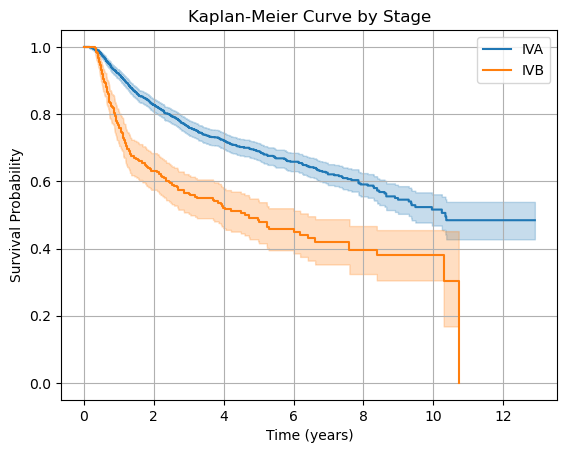

Log-rank test between IVA and IVB: p-value = 2.635802607719304e-15


In [2]:
import pandas as pd
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test, proportional_hazard_test
import matplotlib.pyplot as plt

# Read in data
clinical = pd.read_excel('../Data/RADCURE_Clinical_v04_20241219.xlsx')

# Convert status to binary
clinical['Event'] = clinical['Status'].map({'Dead': 1, 'Alive': 0})

# Fit Kaplan-Meier Estimator 
def plot_km(clinical, group_col, group1, group2):
    kmf = KaplanMeierFitter()
   
    # Subset groups
    group1_data = clinical[clinical[group_col] == group1]
    group2_data = clinical[clinical[group_col] == group2]
        
    # Fit curves
    kmf.fit(group1_data['Length FU'], event_observed=group1_data['Event'], label = group1)
    kmf.plot_survival_function()
    
    kmf.fit(group2_data['Length FU'], event_observed=group2_data['Event'], label = group2)
    kmf.plot_survival_function()
    
    # Plot config
    plt.style.use('default')
    plt.title(f'Kaplan-Meier Curve by {group_col}')
    plt.xlabel('Time (years)')
    plt.ylabel('Survival Probability')
    plt.grid(True)
    plt.show()
    
    # Perform Log-Rank test
    lrt = logrank_test(group1_data['Length FU'], group2_data['Length FU'], 
                       event_observed_A=group1_data['Event'], event_observed_B=group2_data['Event'])
    print(f'Log-rank test between {group1} and {group2}: p-value = {lrt.p_value}')

# Plot curves
plot_km(clinical, 'Smoking Status', 'Current', 'Non-smoker')
plot_km(clinical, 'Stage', 'IVA', 'IVB')



<lifelines.CoxPHFitter: fitted with 3247 total observations, 2223 right-censored observations>
             duration col = 'Length FU'
                event col = 'Event'
      baseline estimation = breslow
   number of observations = 3247
number of events observed = 1024
   partial log-likelihood = -7422.41
         time fit was run = 2025-03-11 17:15:59 UTC

---
                           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                  
Age                        0.05      1.05      0.00            0.05            0.06                1.05                1.06
Sex_Male                  -0.05      0.95      0.08           -0.21            0.10                0.81                1.11
Smoking Status_Ex-smoker  -0.54      0.58      0.07           -0.68           -0.40                0.51                0.67
Smoking Status_Non-smoker -1.03      0.36      0.09           -1.21           -0.85                0.30                0.43
Smoking Status_unknown    -0.28      0.76      0.36           -0.98            0.42                0.37                1.52
Stage_II                   0.20      1.23      0.15           -0.08            0.49                0.92                1.64
Stage_III                  0.50      1.65      0.14            0.23            0.77                1.26                2.15
Stage_IVA                  0.75      2.11      0.12            0.50            0.99                1.66                2.69
Stage_IVB                  1.45      4.28      0.14            1.18            1.73                3.25                5.62

                           cmp to      z      p  -log2(p)
covariate                                                
Age                          0.00  16.68 <0.005    205.08
Sex_Male                     0.00  -0.65   0.52      0.95
Smoking Status_Ex-smoker     0.00  -7.72 <0.005     46.29
Smoking Status_Non-smoker    0.00 -10.99 <0.005     90.89
Smoking Status_unknown       0.00  -0.78   0.43      1.21
Stage_II                     0.00   1.39   0.17      2.59
Stage_III                    0.00   3.68 <0.005     12.09
Stage_IVA                    0.00   6.05 <0.005     29.38
Stage_IVB                    0.00  10.43 <0.005     82.16
---
Concordance = 0.71
Partial AIC = 14862.83
log-likelihood ratio test = 521.80 on 9 df
-log2(p) of ll-ratio test = 351.82

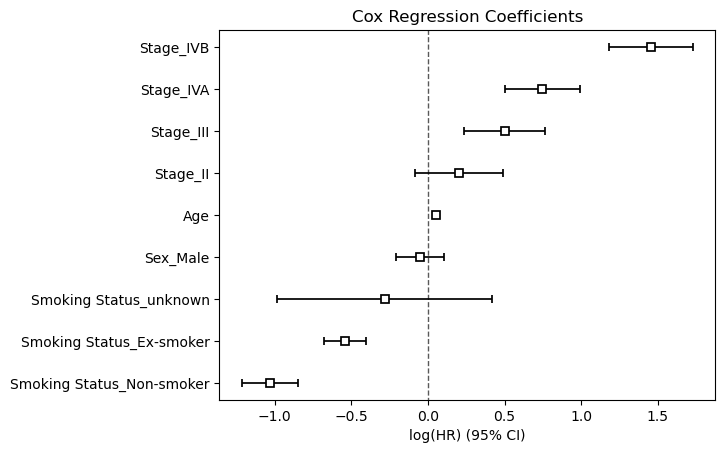

                           test_statistic             p   -log2(p)  \
Age                              4.863449  2.743144e-02   5.188026   
Sex_Male                         3.039819  8.124497e-02   3.621578   
Smoking Status_Ex-smoker         0.076390  7.822499e-01   0.354299   
Smoking Status_Non-smoker        0.009073  9.241136e-01   0.113858   
Smoking Status_unknown           0.338475  5.607109e-01   0.834671   
Stage_II                         0.884909  3.468605e-01   1.527572   
Stage_III                       13.954445  1.872943e-04  12.382406   
Stage_IVA                       25.546196  4.319168e-07  21.142743   
Stage_IVB                       49.735462  1.759370e-12  39.048078   

                          Proportional Hazard Assumption  
Age                                             Violated  
Sex_Male                                    Not Violated  
Smoking Status_Ex-smoker                    Not Violated  
Smoking Status_Non-smoker                   Not Violated  
Smok

In [3]:
# Cox Proportional Hazard Regression 

# Subset dataset
covariates = ['Age', 'Sex', 'Smoking Status', 'Stage']
subset_clin = clinical[['Length FU', 'Event'] + covariates]

# Filter tumor stages based on the threshold (e.g., count >= 50)
stage_counts = subset_clin['Stage'].value_counts()
threshold = 50
valid_stages = stage_counts[stage_counts >= threshold].index

# Filter out stages with low data count
filtered_clin = subset_clin[subset_clin['Stage'].isin(valid_stages)]

# Encode categorical variables
subset_clin_encoded = pd.get_dummies(filtered_clin, columns=['Sex', 'Smoking Status', 'Stage'], drop_first=True)

# Fit the Cox model
cph = CoxPHFitter()
cph.fit(subset_clin_encoded, duration_col='Length FU', event_col='Event')

# Print summary
cph.print_summary()

# Plot the coefficients
cph.plot()
plt.title('Cox Regression Coefficients')
plt.show()

# Perform the proportional hazard test
results = proportional_hazard_test(cph, subset_clin_encoded, time_transform='rank')

# Get results
results_df = results.summary
results_df['Proportional Hazard Assumption'] = results_df['p'].apply(lambda x: 'Violated' if x < 0.05 else 'Not Violated')
print(results_df)


In [ ]:
from sksurv.ensemble import RandomSurvivalForest
from sksurv.util import Surv
from sklearn.impute import SimpleImputer
from sksurv.preprocessing import OneHotEncoder
from sklearn.inspection import permutation_importance

# Random Survival Forest

# Drop columns with too much missing data and uneccessary info
filt_clin = clinical.loc[:, clinical.isnull().mean() <= 0.5]
filt_clin = filt_clin.drop(columns=['HPV', 'RADCURE-challenge', 'ContrastEnhanced']) # Do not want to introduce bias by imputing HPV

# Split data into target (y) and features (X)
y = Surv.from_dataframe('Event', 'Length FU', filt_clin)
X = filt_clin.drop(columns=['Event', 'Length FU'])

# Define column datatypes
num_features = X.select_dtypes(include=['int64', 'float64']).columns
cat_features = X.select_dtypes(exclude=['number', 'datetime']).columns

# Impute missing data
imputer = SimpleImputer(strategy='most_frequent')
filt_clin[cat_features] = imputer.fit_transform(filt_clin[cat_features])

# Encode categorical variables
encoder = OneHotEncoder()
X = encoder.fit_transform(X)

# Train Random Survival Forest
rsf = RandomSurvivalForest(n_estimators=50, random_state=42)
rsf.fit(X, y)